In [ ]:
!pip install -q transformers datasets torchaudio soundfile torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchaudio
import torchcodec

In [ ]:
import torch
from google.colab import drive
from datasets import load_from_disk, Audio
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor



In [ ]:
from datasets import load_dataset


train_dataset = load_dataset("AbstractTTS/IEMOCAP", split="train")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10039 [00:00<?, ? examples/s]

In [ ]:

print("Casting audio to 16kHz...")
train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=16000))

emotion_list = [
    "frustrated", "angry", "sad", "disgust",
    "excited", "fear", "neutral", "surprise", "happy"
]


Casting audio to 16kHz...
Loading base model: facebook/wav2vec2-large...


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Ready for Data Exploration!


In [ ]:
MODEL_CHECKPOINT = "facebook/wav2vec2-large"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading base model: {MODEL_CHECKPOINT}...")
processor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_CHECKPOINT)
model = Wav2Vec2Model.from_pretrained(MODEL_CHECKPOINT)
model.to(device)

print("Ready for Data Exploration!")

Calculating 'Soft' Class Balance...


100%|██████████| 10039/10039 [02:22<00:00, 70.54it/s]


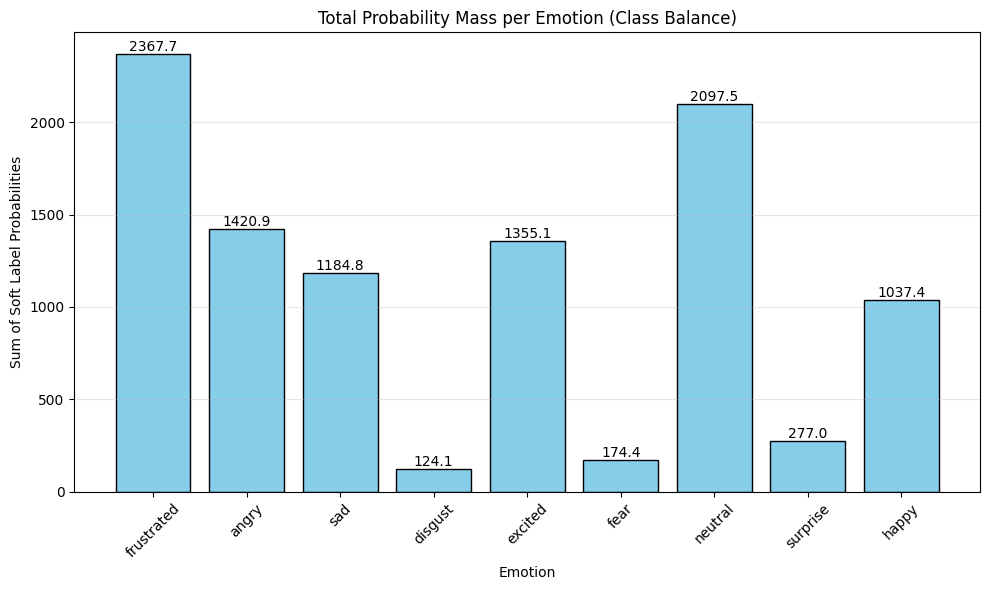

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

emotion_list = [
    "frustrated", "angry", "sad", "disgust",
    "excited", "fear", "neutral", "surprise", "happy"
]

emotion_sums = {e: 0.0 for e in emotion_list}

print("Calculating 'Soft' Class Balance...")
for item in tqdm(train_dataset):
    for e in emotion_list:
        val = item.get(e, 0.0)
        if val is None: val = 0.0
        emotion_sums[e] += float(val)

plt.figure(figsize=(10, 6))
bars = plt.bar(emotion_sums.keys(), emotion_sums.values(), color='skyblue', edgecolor='black')

plt.title("Total Probability Mass per Emotion (Class Balance)")
plt.xlabel("Emotion")
plt.ylabel("Sum of Soft Label Probabilities")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Calculating Cardinality (Threshold > 0.05, then Renormalize)...


100%|██████████| 10039/10039 [02:35<00:00, 64.57it/s]


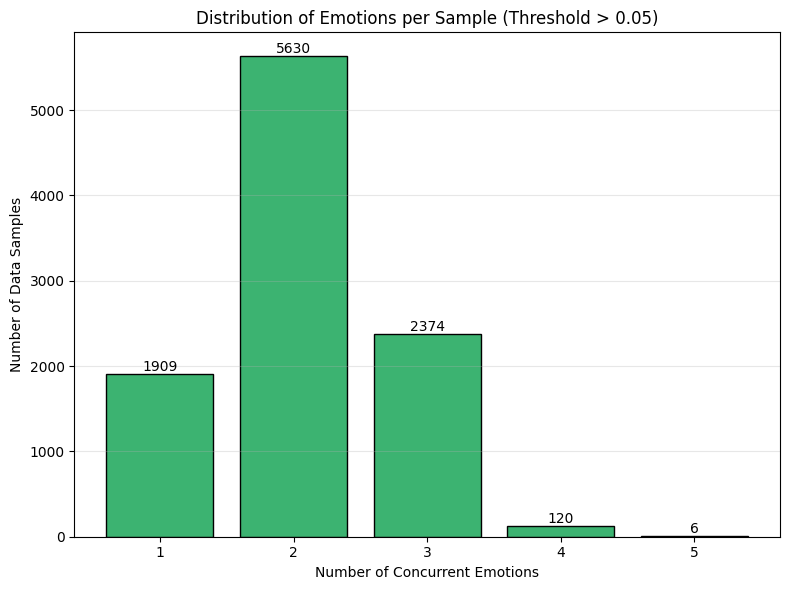


--- Summary (Threshold 0.05) ---
Samples with 1 emotion(s): 1909 (19.0%)
Samples with 2 emotion(s): 5630 (56.1%)
Samples with 3 emotion(s): 2374 (23.6%)
Samples with 4 emotion(s): 120 (1.2%)
Samples with 5 emotion(s): 6 (0.1%)


In [ ]:
import numpy as np
from collections import Counter

emotion_list = [
    "frustrated", "angry", "sad", "disgust",
    "excited", "fear", "neutral", "surprise", "happy"
]

cardinality_counts = Counter()
threshold = 0.05

print(f"Calculating Cardinality (Threshold > {threshold}, then Renormalize)...")

for item in tqdm(train_dataset):
    raw_probs = np.array([float(item.get(e, 0.0) or 0.0) for e in emotion_list])

    mask = raw_probs > threshold
    filtered_probs = raw_probs * mask

    total_mass = filtered_probs.sum()
    if total_mass > 0:
        filtered_probs = filtered_probs / total_mass

    active_count = np.count_nonzero(filtered_probs)

    cardinality_counts[active_count] += 1


sorted_num_emotions = sorted(cardinality_counts.keys())
frequencies = [cardinality_counts[k] for k in sorted_num_emotions]

plt.figure(figsize=(8, 6))
bars = plt.bar(sorted_num_emotions, frequencies, color='mediumseagreen', edgecolor='black')

plt.title(f"Distribution of Emotions per Sample (Threshold > {threshold})")
plt.xlabel("Number of Concurrent Emotions")
plt.ylabel("Number of Data Samples")
plt.xticks(sorted_num_emotions)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

total_samples = sum(frequencies)
print(f"\n--- Summary (Threshold {threshold}) ---")
for num in sorted_num_emotions:
    pct = (cardinality_counts[num] / total_samples) * 100
    print(f"Samples with {num} emotion(s): {cardinality_counts[num]} ({pct:.1f}%)")

Mapping Emotion Combinations (Threshold > 0.05)...


100%|██████████| 10039/10039 [02:12<00:00, 75.73it/s]


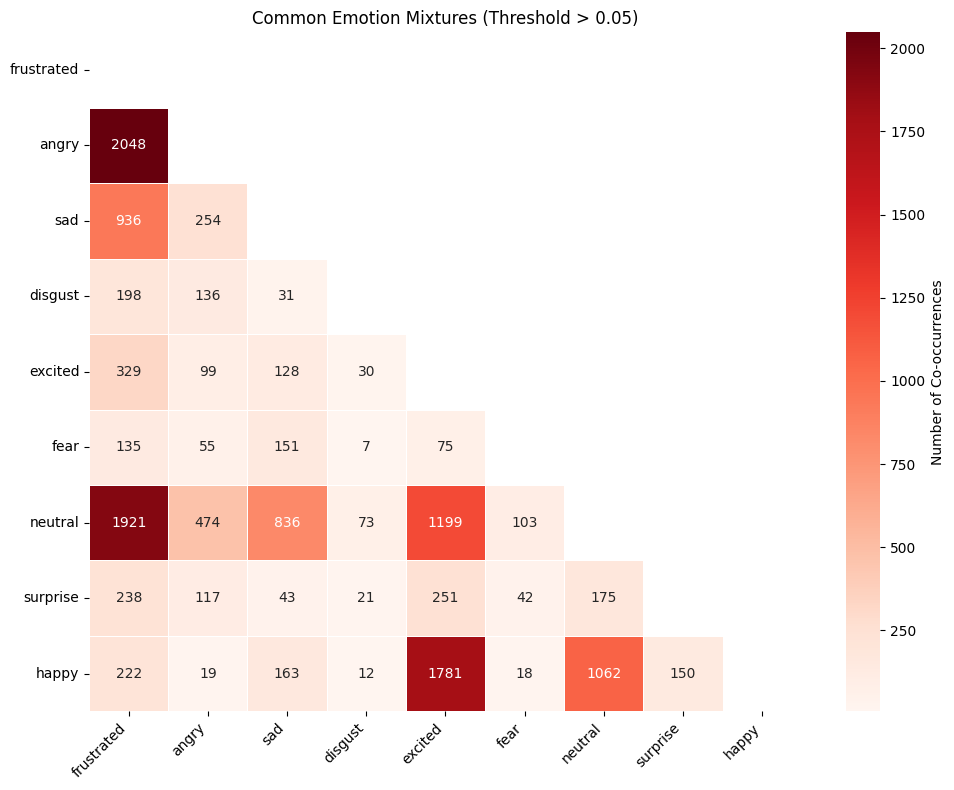

In [ ]:
import seaborn as sns
import pandas as pd
from itertools import combinations

emotion_list = [
    "frustrated", "angry", "sad", "disgust",
    "excited", "fear", "neutral", "surprise", "happy"
]
threshold = 0.05

co_occurrence_matrix = pd.DataFrame(
    0, index=emotion_list, columns=emotion_list
)

for item in tqdm(train_dataset):
    active_emotions = []
    for e in emotion_list:
        val = float(item.get(e, 0.0) or 0.0)
        if val > threshold:
            active_emotions.append(e)

    if len(active_emotions) > 1:
        for e1, e2 in combinations(active_emotions, 2):
            co_occurrence_matrix.loc[e1, e2] += 1
            co_occurrence_matrix.loc[e2, e1] += 1

plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))

sns.heatmap(
    co_occurrence_matrix,
    mask=mask,
    annot=True,
    fmt="d",
    cmap="Reds",
    linewidths=.5,
    cbar_kws={'label': 'Number of Co-occurrences'}
)

plt.title(f"Common Emotion Mixtures (Threshold > {threshold})")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Extracting embeddings for 500 samples...


100%|██████████| 500/500 [32:07<00:00,  3.86s/it]


Running t-SNE (this might take a moment)...


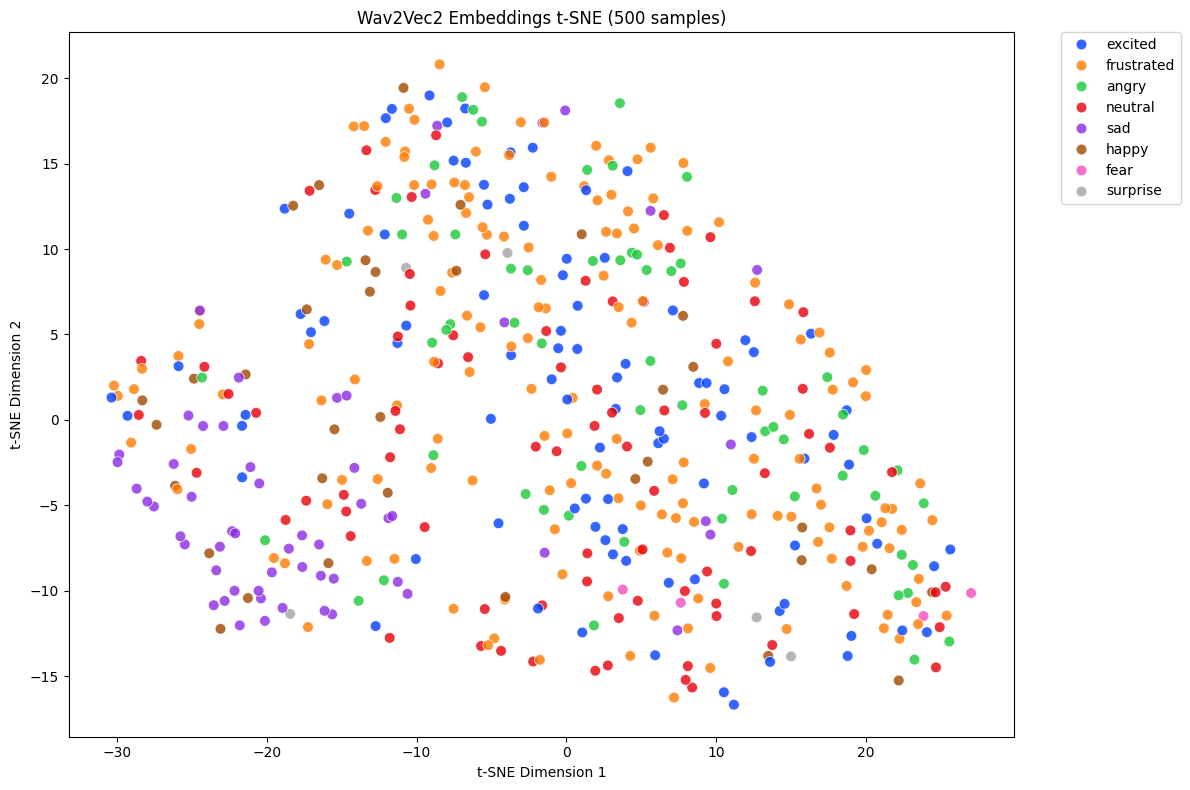

In [ ]:
import torch
from sklearn.manifold import TSNE
import seaborn as sns


N_SAMPLES = 500
device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

indices = np.random.choice(len(train_dataset), N_SAMPLES, replace=False)

embeddings = []
dominant_labels = []

print(f"Extracting embeddings for {N_SAMPLES} samples...")

with torch.no_grad():
    for idx in tqdm(indices):
        item = train_dataset[int(idx)]

        inputs = processor(
            item["audio"]["array"],
            sampling_rate=16000,
            return_tensors="pt"
        )
        input_values = inputs.input_values.to(device)

        outputs = model(input_values)

        hidden_states = outputs.last_hidden_state

        pooled_embedding = torch.mean(hidden_states, dim=1).cpu().numpy().squeeze()
        embeddings.append(pooled_embedding)

        soft_labels = [item[e] for e in emotion_list]
        dominant_idx = np.argmax(soft_labels)
        dominant_labels.append(emotion_list[dominant_idx])

print("Running t-SNE (this might take a moment)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(np.array(embeddings))

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=embeddings_2d[:,0],
    y=embeddings_2d[:,1],
    hue=dominant_labels,
    palette="bright",
    s=60,
    alpha=0.8
)

plt.title(f"Wav2Vec2 Embeddings t-SNE ({N_SAMPLES} samples)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()